# Импортирование библиотек

In [26]:
import numpy as np
from scipy.linalg import lu
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from numpy import linalg as LA
from tqdm import tqdm
from scipy.linalg import orth
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# Реализация алгоритмов

In [2]:
def eigsvd(A: np.ndarray):
    m, n = A.shape
    B = np.dot(A.T, A)
    D, V = np.linalg.eig(B)
    S = np.diag(np.abs(D))
    U = np.dot(np.dot(A, V), np.linalg.inv(S))
    return U, S, V.T

In [3]:
def rSVDPI(A, k, p):
    s = 5
    m, n = A.shape
    O = np.random.randn(n, k+s)
    Q = A @ O
    for i in range(p+1):
        if i < p:
            Q, _ = lu(Q, permute_l=True)
        else:
            Q, _, _ = eigsvd(Q)
            break
        Q = A @ (A.T @ Q)
        
    B = Q.T @ A
    V, S, U = eigsvd(B.T)
    ind = slice(s+1, k+s)
    
    return (Q @ U)[:, ind], S[ind, ind], V[:, ind]

In [4]:
def rSVDBKI(A, k, p, s=5):
    m, n = A.shape

    if s <= 5:
        s = 5

    O = np.random.randn(n, k+s)

    tmp = np.dot(A, O)
    H0, _ = lu(tmp, permute_l=True)
    H = H0
    Hi = H0
    for i in range(1, p):
        Hi, _ = lu(np.dot(A, np.dot(A.T, Hi)), permute_l=True)
        H = np.hstack((H, Hi))
    Q = orth(H)
    B = np.dot(Q.T, A)

    V, S, U = eigsvd(B.T)

    ind = slice((k+s)*(p+1)-k+1,(k+s)*(p+1))

    U, S, V = np.dot(Q, U)[:, ind], S[ind, ind], V[:, ind]

    return U, S, V

# Расчет времени и ошибки для плотных матриц

In [13]:
time_svd_default = []
time_rsvd_default = []
time_eigsvd = []
time_rSVDPI = []
time_rSVDBKI = []

err_svd_default = []
err_rsvd_default = []
err_eigsvd = []

for n in tqdm(range(50, 1000, 50)):
    
    A = np.random.rand(n, n)
    
    start = time.time()
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    time_svd_default.append(time.time() - start)
    err_svd_default.append(LA.norm(A - U*S@Vh, 'fro'))
    
    start = time.time()
    U, S, Vh = randomized_svd(A, n_components=2)
    time_rsvd_default.append(time.time() - start)
    err_rsvd_default.append(LA.norm(A - U*S@Vh, 'fro'))
    
    start = time.time()
    U, S, V = eigsvd(A)
    time_eigsvd.append(time.time() - start)
    err_eigsvd.append(LA.norm(A - U@S@V.T, 'fro'))
    
    start = time.time()
    _ = rSVDPI(A, k=100, p=15)
    time_rSVDPI.append(time.time() - start)
    
    start = time.time()
    _ = rSVDBKI(A, k=100, p=15)
    time_rSVDBKI.append(time.time() - start)

100%|██████████| 19/19 [00:26<00:00,  1.37s/it]


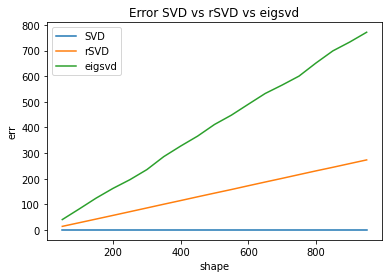

In [18]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, err_svd_default, label='SVD')
plt.plot(x, err_rsvd_default, label='rSVD')
plt.plot(x, err_eigsvd, label='eigsvd')

# добавление легенды и заголовка
plt.legend()
plt.title('Error SVD vs rSVD vs eigsvd')
plt.xlabel('shape')
plt.ylabel('err')
# отображение графика
plt.show() 


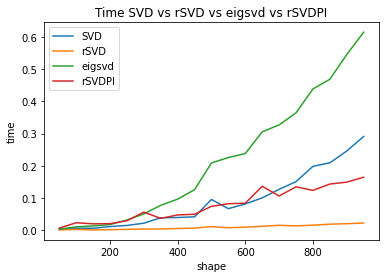

In [24]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, time_svd_default, label='SVD')
plt.plot(x, time_rsvd_default, label='rSVD')
plt.plot(x, time_eigsvd, label='eigsvd')
plt.plot(x, time_rSVDPI, label='rSVDPI')
#plt.plot(x, time_rSVDBKI, label='rSVDBKI')
# добавление легенды и заголовка
plt.legend()
plt.title('Time SVD vs rSVD vs eigsvd vs rSVDPI')
plt.xlabel('shape')
plt.ylabel('time')
# отображение графика
plt.show() 

# Расчет времени и ошибки для разреженных матриц

In [41]:
time_svd_default = []
time_rsvd_default = []
time_eigsvd = []
time_rSVDPI = []
time_rSVDBKI = []

err_svd_default = []
err_rsvd_default = []
err_eigsvd = []

for n in tqdm(range(50, 1000, 50)):
    
    rng = default_rng()
    rvs = stats.poisson(25, loc=10).rvs
    A = random(n, n, density=0.25, random_state=rng, data_rvs=rvs)
    A = A.A
    
    start = time.time()
    U, S, Vh = svds(A, k=40)
    time_svd_default.append(time.time() - start)
    err_svd_default.append(LA.norm(A - U@np.diag(S)@Vh, 'fro'))
    
    start = time.time()
    U, S, Vh = randomized_svd(A, n_components=2)
    time_rsvd_default.append(time.time() - start)
    err_rsvd_default.append(LA.norm(A - U*S@Vh, 'fro'))
    
    start = time.time()
    U, S, V = eigsvd(A)
    time_eigsvd.append(time.time() - start)
    err_eigsvd.append(LA.norm(A - U@S@V.T, 'fro'))
    
    start = time.time()
    _ = rSVDPI(A, k=40, p=15)
    time_rSVDPI.append(time.time() - start)
    
    start = time.time()
    _ = rSVDBKI(A, k=40, p=15)
    time_rSVDBKI.append(time.time() - start)

100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


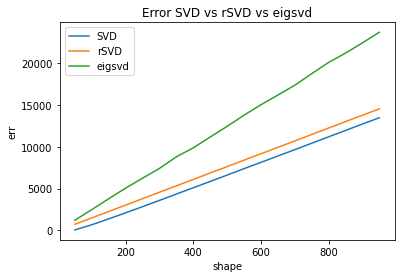

In [43]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, err_svd_default, label='SVD')
plt.plot(x, err_rsvd_default, label='rSVD')
plt.plot(x, err_eigsvd, label='eigsvd')

# добавление легенды и заголовка
plt.legend()
plt.title('Error SVD vs rSVD vs eigsvd')
plt.xlabel('shape')
plt.ylabel('err')
# отображение графика
plt.show() 

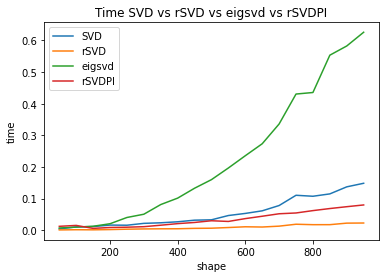

In [45]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, time_svd_default, label='SVD')
plt.plot(x, time_rsvd_default, label='rSVD')
plt.plot(x, time_eigsvd, label='eigsvd')
plt.plot(x, time_rSVDPI, label='rSVDPI')
#plt.plot(x, time_rSVDBKI, label='rSVDBKI')
# добавление легенды и заголовка
plt.legend()
plt.title('Time SVD vs rSVD vs eigsvd vs rSVDPI')
plt.xlabel('shape')
plt.ylabel('time')
# отображение графика
plt.show() 

In [224]:
(U@S@V.T).shape

(500, 300)

In [250]:
LA.norm(A - U@S@V.T, 'fro')

223.76769607014143

In [241]:
U@S@V.T

array([[ 0.04387175, -0.01735955,  0.0156958 , ...,  0.02695078,
        -0.14977425,  0.14387588],
       [ 0.0273283 ,  0.03221974, -0.07712664, ..., -0.05099114,
        -0.00093326,  0.06784605],
       [-0.01373319, -0.00739069,  0.05238622, ..., -0.01745405,
         0.13370583,  0.10198096],
       ...,
       [ 0.01670569, -0.05855445,  0.00822658, ...,  0.0772985 ,
         0.01741711, -0.10751003],
       [-0.1074149 ,  0.07183658, -0.07024155, ...,  0.09166863,
        -0.16747033,  0.04587921],
       [ 0.13850229, -0.09394385, -0.08304716, ..., -0.07025742,
         0.01383975, -0.02073313]])

In [259]:
U, S, Vh = randomized_svd(A, n_components=2)

In [262]:
U*S@Vh

array([[0.55260187, 0.53104766, 0.53502462, ..., 0.53797623, 0.57892347,
        0.57100823],
       [0.50602845, 0.47617565, 0.46228483, ..., 0.57460068, 0.48046039,
        0.56364309],
       [0.47703663, 0.46554281, 0.48130483, ..., 0.40677318, 0.53468763,
        0.46426395],
       ...,
       [0.50991488, 0.48194237, 0.47160135, ..., 0.56191964, 0.49450958,
        0.55947148],
       [0.51229668, 0.48891394, 0.48670652, ..., 0.52629375, 0.51999943,
        0.54306352],
       [0.51933151, 0.49160907, 0.48240591, ..., 0.56608432, 0.50740639,
        0.56671401]])

In [263]:
A

array([[0.58469258, 0.96906803, 0.25257079, ..., 0.09904593, 0.98996254,
        0.62678309],
       [0.68455357, 0.87524318, 0.24039731, ..., 0.99811452, 0.93667386,
        0.79550161],
       [0.92701022, 0.84918076, 0.51896018, ..., 0.80452057, 0.90357451,
        0.69438736],
       ...,
       [0.48280476, 0.15931343, 0.47283321, ..., 0.24599236, 0.06101861,
        0.65706638],
       [0.74706037, 0.71607659, 0.75228393, ..., 0.20527558, 0.19028783,
        0.99182852],
       [0.80458752, 0.17628683, 0.89779274, ..., 0.70533203, 0.52931218,
        0.9165331 ]])